<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/Synthetic_Data_with_CDF_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [ ]:
! pip install shap &> /dev/null

In [ ]:
import os #  for environment operations
import random # for generating random numbers
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import tensorflow as tf # for building deep learning models
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from scipy.stats import ks_2samp
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
import shap


In [ ]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

### Upload the dataset and data handling

In [ ]:
df=pd.read_csv('/content/ausprivauto0405.csv')

In [ ]:
print(df.shape)

(67856, 9)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [ ]:
print(df.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [ ]:
df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [ ]:
df_duplicated_rows=df[df.duplicated()]
df_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [ ]:
df=df.drop_duplicates()

In [ ]:
df_duplicated_col=df.columns[df.columns.duplicated()]
df_duplicated_col

Index([], dtype='object')

In [ ]:
missing=df.isnull().sum()/df.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [ ]:
print(df['VehAge'].unique())
print(df['DrivAge'].unique())
print(df['VehBody'].unique())
print(df['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [ ]:
df_encod=df.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df_encod['VehAge'] = df_encod['VehAge'].map(VehAge_group)
df_encod['VehAge']= df_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df_encod['DrivAge'] = df_encod['DrivAge'].map(DrivAge_group)
df_encod['DrivAge']= df_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df_encod['VehBody'] = df_encod['VehBody'].map(VehBody_group)
df_encod['VehBody']= df_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df_encod['Gender'] = df_encod['Gender'].map(Gender_group)
df_encod['Gender']= df_encod['Gender'].astype(int)




In [ ]:
df_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [ ]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df_encod, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(53320, 9)

### Build a CDF

In [ ]:
## Data Preparation
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Define columns
condition_col = 'ClaimOcc'          # Binary condition
target_discrete = 'ClaimNb'         # Discrete variable
target_continuous = 'ClaimAmount'   # Continuous variable

# Define features to include 'ClaimNb' and 'ClaimAmount' and exclude 'ClaimOcc'
features = [col for col in X_train.columns if col != condition_col]

# Extract features and condition, ensuring float32 data type
X_features = X_train[features].values.astype(np.float32)        # Ensure float32
X_condition = X_train[condition_col].values.reshape(-1, 1).astype(np.float32)  # Ensure float32

# Normalize all features using standard normalization
means = np.mean(X_features, axis=0).astype(np.float32)
stds = np.std(X_features, axis=0).astype(np.float32)
# To avoid division by zero
stds_corrected = np.where(stds == 0, 1, stds).astype(np.float32)
X_features_normalized = (X_features - means) / stds_corrected
X_features_normalized = X_features_normalized.astype(np.float32)  # Ensure float32

# Prepare the input for the diffusion model (features + condition)
X_input = np.concatenate([X_features_normalized, X_condition], axis=1).astype(np.float32)  # Ensure float32

# Define dimensions
input_dim = X_input.shape[1]        # Number of features + condition
condition_dim = 1                   # Since ClaimOcc is binary

print(f"Shape of X_input: {X_input.shape}")

## Define diffusion process
class DiffusionModel:
    def __init__(self, input_dim, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.input_dim = input_dim
        self.timesteps = timesteps

        # Linear beta schedule with float32
        self.beta = np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = np.cumprod(self.alpha).astype(np.float32)
        self.alpha_cumprod_prev = np.concatenate(
            (np.array([1.0], dtype=np.float32), self.alpha_cumprod[:-1])
        ).astype(np.float32)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = tf.random.normal(shape=x_start.shape, dtype=tf.float32)  # Ensure float32
        # Convert alpha_cumprod to float32 tensors
        alpha_cumprod = tf.constant(self.alpha_cumprod, dtype=tf.float32)
        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_cumprod = tf.gather(alpha_cumprod, t)[:, None]
        sqrt_one_minus_alpha_cumprod = tf.gather(one - alpha_cumprod, t)[:, None]
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

def build_unet(input_dim, condition_dim, timesteps=1000):
    """
    Builds a U-Net-like architecture for tabular data.

    Parameters:
    - input_dim: Dimension of the input features including condition
    - condition_dim: Dimension of the condition variable
    - timesteps: Number of diffusion timesteps

    Returns:
    - A Keras Model representing the U-Net denoising network
    """
    # Inputs
    x_input = layers.Input(shape=(input_dim,), dtype='float32', name='input_features')
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timesteps')  # Timestep
    condition_input = layers.Input(shape=(condition_dim,), dtype='float32', name='condition')

    # Timestep Embedding
    t_embed = layers.Embedding(input_dim=timesteps, output_dim=64, dtype='float32')(t_input)
    t_embed = layers.Dense(64, activation='relu')(t_embed)
    t_embed = layers.Dense(64, activation='relu')(t_embed)

    # Concatenate all inputs
    x = layers.Concatenate()([x_input, condition_input, t_embed])

    # Encoder
    encoder_layer1 = layers.Dense(512, activation='relu')(x)
    encoder_layer2 = layers.Dense(512, activation='relu')(encoder_layer1)
    encoder_layer3 = layers.Dense(512, activation='relu')(encoder_layer2)

    # Bottleneck
    bottleneck = layers.Dense(512, activation='relu')(encoder_layer3)

    # Decoder
    decoder_layer1 = layers.Dense(512, activation='relu')(bottleneck)
    decoder_layer1 = layers.Concatenate()([decoder_layer1, encoder_layer3])  # Skip connection

    decoder_layer2 = layers.Dense(512, activation='relu')(decoder_layer1)
    decoder_layer2 = layers.Concatenate()([decoder_layer2, encoder_layer2])  # Skip connection

    decoder_layer3 = layers.Dense(512, activation='relu')(decoder_layer2)
    decoder_layer3 = layers.Concatenate()([decoder_layer3, encoder_layer1])  # Skip connection

    # Output
    output = layers.Dense(input_dim, activation='linear')(decoder_layer3)

    # Define the model
    model = Model(inputs=[x_input, t_input, condition_input], outputs=output, name='UNet_DiffusionModel')
    return model

# Start the U-Net denoising model
unet_model = build_unet(input_dim=input_dim, condition_dim=condition_dim, timesteps=1000)
unet_model.summary()

# Start the diffusion process
diffusion = DiffusionModel(input_dim=input_dim, timesteps=1000)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training parameters
batch_size = 96
epochs = 20
steps_per_epoch = X_input.shape[0] // batch_size

# Prepare TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_input, X_input[:, -condition_dim:]))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

@tf.function
def train_step(x, condition):
    # Sample random timestep for each example in the batch
    t = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=1000, dtype=tf.int32)

    # Sample noise
    noise = tf.random.normal(shape=x.shape, dtype=tf.float32)  # Ensure float32

    # Get noised data
    x_noised = diffusion.q_sample(x, t, noise)

    with tf.GradientTape() as tape:
        # Predict the noise
        noise_pred = unet_model([x_noised, t, condition], training=True)
        # Compute loss
        loss = tf.reduce_mean(tf.square(noise - noise_pred))

    # Backpropagation
    gradients = tape.gradient(loss, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))

    return loss

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    for step, (x_batch, condition_batch) in enumerate(tqdm(dataset, desc=f"Epoch {epoch + 1}/{epochs}")):
        loss = train_step(x_batch, condition_batch)
        epoch_loss += loss.numpy()
    epoch_loss /= steps_per_epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

def sample_diffusion(model, diffusion, condition, num_samples):
    """
    Generates samples by reversing the diffusion process.

    Parameters:
    - model: The trained denoising model
    - diffusion: The diffusion process instance
    - condition: Condition tensor
    - num_samples: Number of samples to generate

    Returns:
    - Tensor containing generated samples
    """
    x = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
    for t in tqdm(range(diffusion.timesteps - 1, -1, -1), desc="Sampling"):
        t_tensor = tf.fill([num_samples], t)
        noise_pred = model([x, t_tensor, condition], training=False)

        beta_t = diffusion.beta[t]
        alpha_t = diffusion.alpha[t]
        alpha_cumprod_t = diffusion.alpha_cumprod[t]
        alpha_cumprod_prev_t = diffusion.alpha_cumprod_prev[t]

        # Convert to float32 tensors
        beta_t = tf.constant(beta_t, dtype=tf.float32)
        alpha_t = tf.constant(alpha_t, dtype=tf.float32)
        alpha_cumprod_t = tf.constant(alpha_cumprod_t, dtype=tf.float32)

        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_t = tf.sqrt(alpha_t)
        inv_sqrt_alpha_t = one / sqrt_alpha_t

        one_minus_alpha_t = one - alpha_t
        sqrt_one_minus_alpha_cumprod_t = tf.sqrt(one - alpha_cumprod_t)
        inv_sqrt_one_minus_alpha_cumprod_t = one / sqrt_one_minus_alpha_cumprod_t

        # Compute x
        x = inv_sqrt_alpha_t * (x - (one_minus_alpha_t * inv_sqrt_one_minus_alpha_cumprod_t) * noise_pred)

        if t > 0:
            noise = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
            x = x + tf.sqrt(beta_t) * noise
    return x



def generate_synthetic_data(model, diffusion, num_samples, claim_occ_value=0,
                            columns_to_round=None, exposure_mean=None,
                            min_claim_amount=None):
    """
    Generates synthetic data with specified ClaimOcc value, incorporating CVAE constraints.

    Parameters:
    - model: The trained denoising model (UNet)
    - diffusion: The diffusion process instance
    - num_samples: Number of samples to generate
    - claim_occ_value: Value of ClaimOcc to condition on (0 or 1)
    - columns_to_round: List of column names to round to nearest integer
    - exposure_mean: Mean value of 'Exposure' to replace zeros
    - min_claim_amount: Minimum value to enforce for 'ClaimAmount' when 'ClaimNb' > 0

    Returns:
    - DataFrame containing generated synthetic data
    """
    # Define conditions
    condition = np.full((num_samples, condition_dim), claim_occ_value).astype(np.float32)

    # Convert to tensor
    condition_tensor = tf.convert_to_tensor(condition, dtype=tf.float32)

    # Generate samples
    generated_noised = sample_diffusion(model, diffusion, condition_tensor, num_samples)

    # Convert to numpy array
    generated_noised = generated_noised.numpy()

    # Separate features and condition_col
    generated_features_noised = generated_noised[:, :-1]  # Assuming last column is condition_col

    # Rescale features to original scale
    generated_features = generated_features_noised * stds_corrected + means

    # Convert to DataFrame
    generated_data = pd.DataFrame(generated_features, columns=features)

    # Assign the condition variable
    generated_data[condition_col] = claim_occ_value

    # Handle discrete variables: 'ClaimNb'
    if target_discrete in features:
        claim_nb_idx = features.index(target_discrete)
        # Round 'ClaimNb' to the nearest integer
        generated_data[target_discrete] = np.round(generated_data[target_discrete]).astype(int)
    else:
        raise ValueError(f"Target discrete column '{target_discrete}' not found in features.")

    # Handle 'ClaimAmount' based on 'ClaimNb'
    if target_continuous in features:
        claim_amount_idx = features.index(target_continuous)
        generated_claim_nb = generated_data[target_discrete].values
        # Set 'ClaimAmount' to 0 where 'ClaimNb' is 0
        generated_data[target_continuous] = np.where(generated_claim_nb == 0, 0, generated_data[target_continuous])

        if min_claim_amount is not None:
            # Enforce minimum 'ClaimAmount' where 'ClaimNb' > 0
            generated_data[target_continuous] = np.where(
                generated_claim_nb > 0,
                generated_data[target_continuous].clip(lower=min_claim_amount),
                generated_data[target_continuous]
            )
    else:
        raise ValueError(f"Target continuous column '{target_continuous}' not found in features.")

    # Post-processing: Round Specific Columns and Clip Negative Values
    if columns_to_round is not None:
        # Check if these columns exist in the generated data
        missing_round_columns = [col for col in columns_to_round if col not in generated_data.columns]
        if missing_round_columns:
            raise ValueError(f"The following columns to round are missing in generated data: {missing_round_columns}")

        # Round the specified columns to nearest integer
        generated_data[columns_to_round] = generated_data[columns_to_round].round().astype(int)

    # Replace negative values with zero for all numerical columns
    numerical_cols = generated_data.select_dtypes(include=[np.number]).columns.tolist()
    generated_data[numerical_cols] = generated_data[numerical_cols].clip(lower=0)

    # Replace zero 'Exposure' with average exposure if provided
    if exposure_mean is not None and 'Exposure' in generated_data.columns:
        generated_data['Exposure'] = np.where(
            generated_data['Exposure'] == 0,
            exposure_mean,
            generated_data['Exposure']
        )

    return generated_data

# Define CVAE-like constraints
columns_to_round = ['VehAge', 'DrivAge', 'VehBody', 'Gender']
exposure_mean = X_train['Exposure'].mean()
min_claim_amount = X_train['ClaimAmount'].mean()  # Or another suitable value based on your data

# Define generation parameters
num_samples = 53320
num_samples_claim0 = 49617
num_samples_claim1 = num_samples - num_samples_claim0

# Generate samples with ClaimOcc=0
synthetic_data_claim0 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim0,
    claim_occ_value=0,
    columns_to_round=columns_to_round,
    exposure_mean=exposure_mean,
    min_claim_amount=min_claim_amount
)

# Generate samples with ClaimOcc=1
synthetic_data_claim1 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim1,
    claim_occ_value=1,
    columns_to_round=columns_to_round,
    exposure_mean=exposure_mean,
    min_claim_amount=min_claim_amount
)

# Combine the datasets
synthetic_data = pd.concat([synthetic_data_claim0, synthetic_data_claim1], ignore_index=True)

# Shuffle the dataset to mix ClaimOcc=0 and ClaimOcc=1 samples
synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)



Shape of X_input: (53320, 9)


Model: "UNet_DiffusionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ timesteps (InputLayer)    │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 64)             │         64,000 │ timesteps[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_features            │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ condition (InputLayer)    │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          4,160 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 74)             │              0 │ input_features[0][0],  │
│                           │                        │                │ condition[0][0],       │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │         38,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │        262,656 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        262,656 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │        262,656 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        262,656 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1024)           │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        524,800 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1024)           │              0 │ dense_7[0][0],         │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 512)            │        524,800 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 1024)           │              0 │ dense_8[0][0],         │
│ (Concatenate)        

 Total params: 2,220,169 (8.47 MB)

 Trainable params: 2,220,169 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20: 100%|██████████| 556/556 [00:07<00:00, 70.29it/s] 


Epoch 1/20, Loss: 0.2627


Epoch 2/20: 100%|██████████| 556/556 [00:03<00:00, 169.57it/s]


Epoch 2/20, Loss: 0.2012


Epoch 3/20: 100%|██████████| 556/556 [00:03<00:00, 162.96it/s]


Epoch 3/20, Loss: 0.1886


Epoch 4/20: 100%|██████████| 556/556 [00:03<00:00, 160.53it/s]


Epoch 4/20, Loss: 0.1771


Epoch 5/20: 100%|██████████| 556/556 [00:03<00:00, 177.20it/s]


Epoch 5/20, Loss: 0.1747


Epoch 6/20: 100%|██████████| 556/556 [00:03<00:00, 185.04it/s]


Epoch 6/20, Loss: 0.1703


Epoch 7/20: 100%|██████████| 556/556 [00:02<00:00, 185.88it/s]


Epoch 7/20, Loss: 0.1667


Epoch 8/20: 100%|██████████| 556/556 [00:03<00:00, 175.84it/s]


Epoch 8/20, Loss: 0.1628


Epoch 9/20: 100%|██████████| 556/556 [00:02<00:00, 187.79it/s]


Epoch 9/20, Loss: 0.1619


Epoch 10/20: 100%|██████████| 556/556 [00:03<00:00, 176.87it/s]


Epoch 10/20, Loss: 0.1627


Epoch 11/20: 100%|██████████| 556/556 [00:03<00:00, 183.18it/s]


Epoch 11/20, Loss: 0.1593


Epoch 12/20: 100%|██████████| 556/556 [00:03<00:00, 184.48it/s]


Epoch 12/20, Loss: 0.1563


Epoch 13/20: 100%|██████████| 556/556 [00:03<00:00, 182.61it/s]


Epoch 13/20, Loss: 0.1548


Epoch 14/20: 100%|██████████| 556/556 [00:03<00:00, 178.42it/s]


Epoch 14/20, Loss: 0.1527


Epoch 15/20: 100%|██████████| 556/556 [00:03<00:00, 184.38it/s]


Epoch 15/20, Loss: 0.1530


Epoch 16/20: 100%|██████████| 556/556 [00:03<00:00, 182.24it/s]


Epoch 16/20, Loss: 0.1538


Epoch 17/20: 100%|██████████| 556/556 [00:02<00:00, 187.98it/s]


Epoch 17/20, Loss: 0.1489


Epoch 18/20: 100%|██████████| 556/556 [00:02<00:00, 189.65it/s]


Epoch 18/20, Loss: 0.1505


Epoch 19/20: 100%|██████████| 556/556 [00:02<00:00, 189.07it/s]


Epoch 19/20, Loss: 0.1490


Epoch 20/20: 100%|██████████| 556/556 [00:02<00:00, 188.83it/s]


Epoch 20/20, Loss: 0.1481


Sampling: 100%|██████████| 1000/1000 [00:19<00:00, 50.26it/s]


In [ ]:
new_samples_df=synthetic_data.copy()

### Data Comparison

In [ ]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [ ]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.540541,1.065619,2,6,1,3,1,447.626373,1
1,0.455923,1.043630,3,3,1,5,0,0.000000,0
2,0.200652,1.570566,3,2,0,3,0,0.000000,0
3,0.053112,1.538718,3,2,1,1,0,0.000000,0
4,0.953587,1.472368,3,4,0,1,0,0.000000,0


In [ ]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.506836,0.265893,0.000007,0.293611,0.492145,0.716250,1.155839
VehValue,53320.0,1.829083,1.027344,0.000000,1.112509,1.665828,2.342168,12.210808
VehAge,53320.0,2.425900,1.047667,1.000000,1.000000,3.000000,3.000000,4.000000
VehBody,53320.0,3.792854,2.064822,0.000000,2.000000,3.000000,6.000000,14.000000
Gender,53320.0,0.441917,0.496620,0.000000,0.000000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.214235,1.497786,1.000000,2.000000,3.000000,4.000000,7.000000
ClaimNb,53320.0,0.069824,0.256320,0.000000,0.000000,0.000000,0.000000,2.000000
ClaimAmount,53320.0,87.645172,492.996905,0.000000,0.000000,0.000000,0.000000,16869.464844
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [ ]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [Exposure, VehValue, VehAge, VehBody, Gender, DrivAge, ClaimNb, ClaimAmount, ClaimOcc]
Index: []


### Visual Comparison

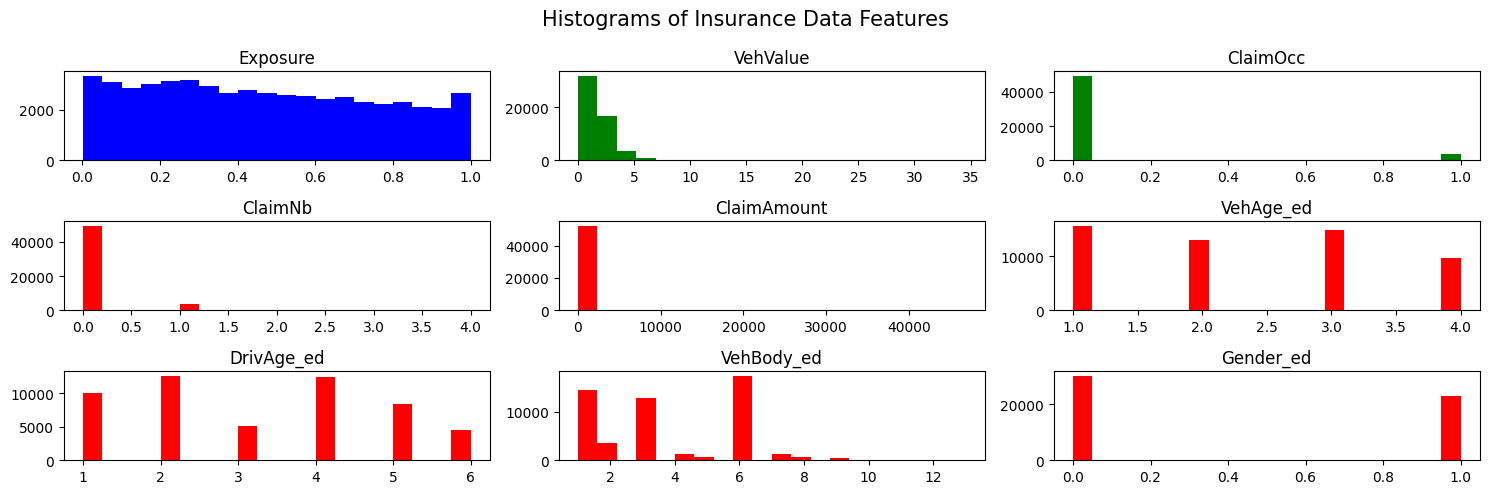

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(X_train['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(X_train['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(X_train['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(X_train['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(X_train['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(X_train['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(X_train['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(X_train['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(X_train['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

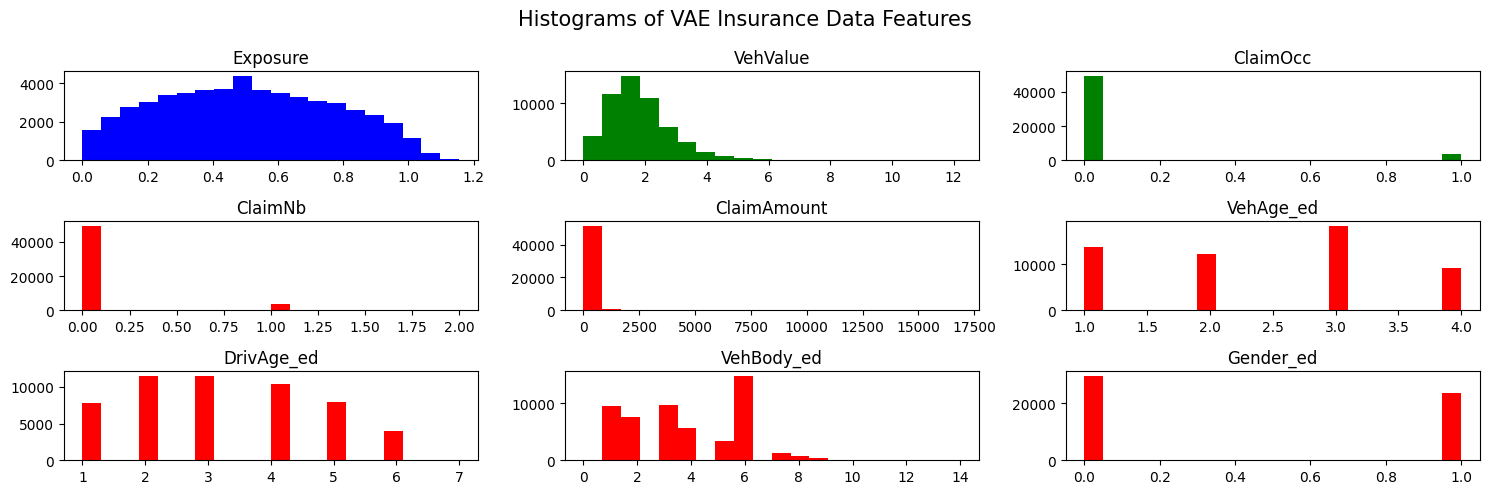

In [ ]:
# Plot histograms of the original features for visualization
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = subplots(nrows=3,ncols=3)

ax[0,0].hist(new_samples_df['Exposure'], bins=20, color='blue')
ax[0,0].set_title('Exposure')

ax[0,1].hist(new_samples_df['VehValue'], bins=20, color='green')
ax[0,1].set_title('VehValue')

ax[0,2].hist(new_samples_df['ClaimOcc'], bins=20, color='green')
ax[0,2].set_title('ClaimOcc')

ax[1,0].hist(new_samples_df['ClaimNb'], bins=20, color='red')
ax[1,0].set_title('ClaimNb')

ax[1,1].hist(new_samples_df['ClaimAmount'], bins=20, color='red')
ax[1,1].set_title('ClaimAmount')

ax[1,2].hist(new_samples_df['VehAge'], bins=20, color='red')
ax[1,2].set_title('VehAge_ed')

ax[2,0].hist(new_samples_df['DrivAge'], bins=20, color='red')
ax[2,0].set_title('DrivAge_ed')

ax[2,1].hist(new_samples_df['VehBody'], bins=20, color='red')
ax[2,1].set_title('VehBody_ed')

ax[2,2].hist(new_samples_df['Gender'], bins=20, color='red')
ax[2,2].set_title('Gender_ed')


plt.suptitle('Histograms of VAE Insurance Data Features', fontsize=15)
plt.tight_layout()
plt.show()

### Statistical Analysis

In [ ]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.09099774943735933, P-value=1.4846982499303151e-192
KS Test for VehValue: Statistic=0.08090772693173293, P-value=2.972787501363508e-152
KS Test for VehAge: Statistic=0.05206301575393846, P-value=3.0293945047908864e-63
KS Test for VehBody: Statistic=0.0936234058514629, P-value=7.997610650751802e-204
KS Test for Gender: Statistic=0.010765191297824384, P-value=0.004114009049787329
KS Test for DrivAge: Statistic=0.06303450862715682, P-value=1.5592795660829457e-92
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0
KS Test for ClaimNb: Statistic=0.0040322580645161255, P-value=0.7773111966934223
KS Test for ClaimAmount: Statistic=0.006639159789947446, P-value=0.18968311834622442


### PCA Analysis

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_sc = scaler.fit_transform(X_train)
pca_train = PCA(n_components=3).fit_transform(X_train_sc)


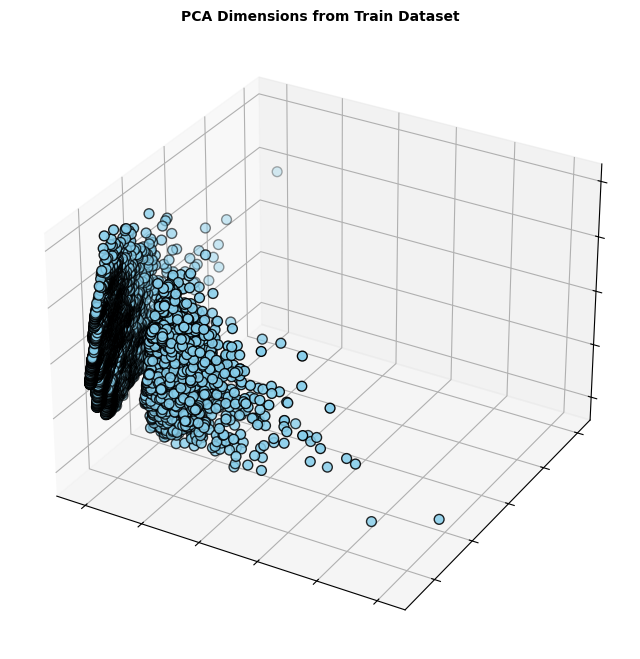

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_train[:, 0],  # 1st principal component
    pca_train[:, 1],  # 2nd principal component
    pca_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
new_samples_sc = scaler.fit_transform(new_samples_df)
pca_new_samples = PCA(n_components=3).fit_transform(new_samples_sc)


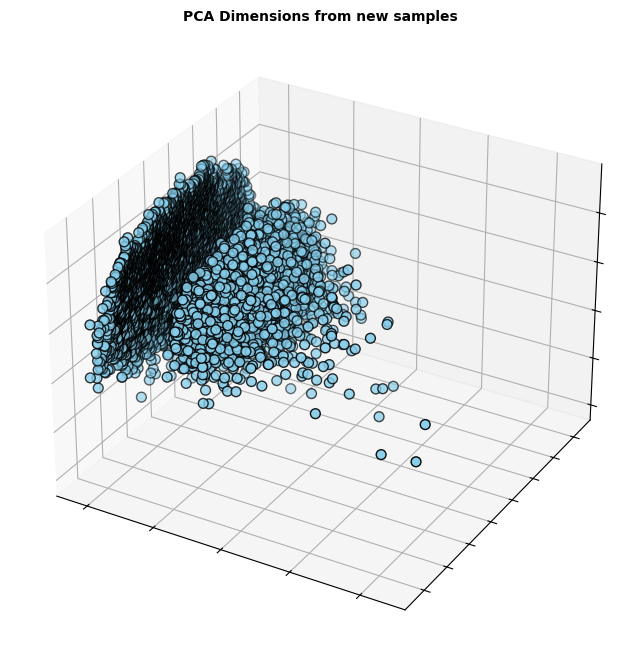

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    pca_new_samples[:, 0],  # 1st principal component
    pca_new_samples[:, 1],  # 2nd principal component
    pca_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("PCA Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### UMAP Analysis

In [ ]:
umap_train = umap.UMAP(n_components=3).fit_transform(X_train_sc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


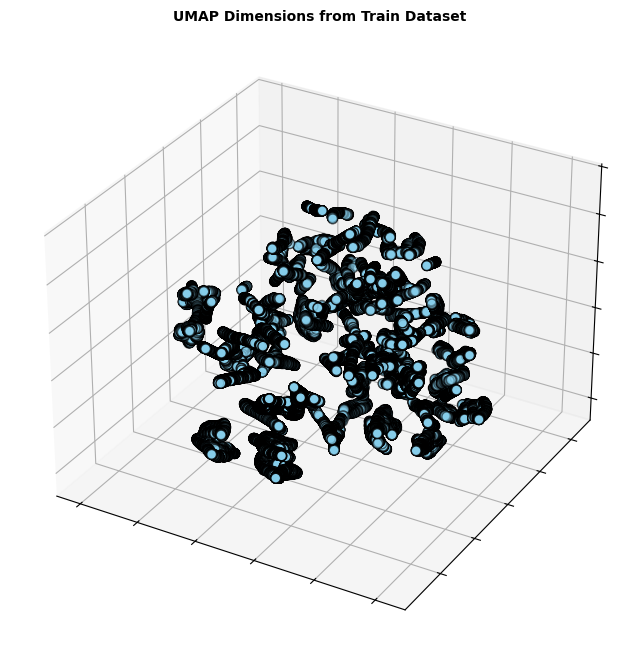

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_train[:, 0],  # 1st principal component
    umap_train[:, 1],  # 2nd principal component
    umap_train[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from Train Dataset", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

In [ ]:
umap_new_samples = umap.UMAP(n_components=3).fit_transform(new_samples_sc)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


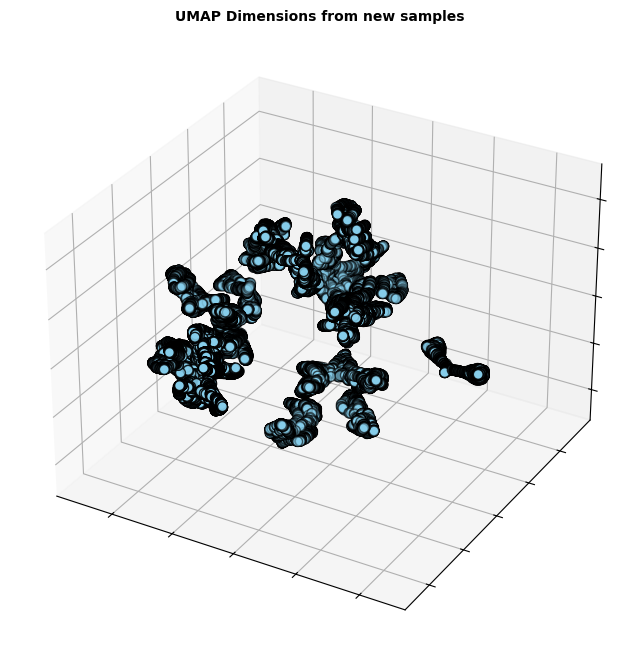

In [ ]:
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot using the first three principal components
scatter = ax.scatter(
    umap_new_samples[:, 0],  # 1st principal component
    umap_new_samples[:, 1],  # 2nd principal component
    umap_new_samples[:, 2],  # 3rd principal component
    c='skyblue',       # Color of the points
    edgecolor='k',     # Edge color for points
    s=50               # Size of the points
)

# Set the title and labels
ax.set_title("UMAP Dimensions from new samples", fontsize=10, weight='bold')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


# Show the plot
plt.show()

### GLM Frequency Analysis

In [ ]:
X_train_freq=X_train.copy()
X_test_freq=X_test.copy()

exposure_tr_freq=X_train_freq['Exposure']
y_train_nb=X_train_freq['ClaimNb']
exposure_te_freq=X_test_freq['Exposure']
y_test_nb=X_test_freq['ClaimNb']
X_train_freq_=X_train_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_freq_=X_test_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_nb=TweedieRegressor(power=1, link='log')
glm_nb.fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_nb_pred_tr = glm_nb.predict(X_train_freq_)
glm_nb_pred_te = glm_nb.predict(X_test_freq_)
mpd_train_1 = mean_poisson_deviance(y_train_nb/exposure_tr_freq, glm_nb_pred_tr)
mpd_test_1 = mean_poisson_deviance(y_test_nb/exposure_te_freq, glm_nb_pred_te)

In [ ]:
mpd_train_1

1.4344568519034897

In [ ]:
mpd_test_1

1.741190103494106

In [ ]:
X_train_sample_freq=new_samples_df.copy()
X_test_sample_freq=X_test.copy()

exposure_sample_tr_freq=X_train_sample_freq['Exposure']
y_train_sample_nb=X_train_sample_freq['ClaimNb']
exposure_sample_te_freq=X_test_sample_freq['Exposure']
y_test_sample_nb=X_test_sample_freq['ClaimNb']
X_train_sample_freq_=X_train_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_sample_freq_=X_test_sample_freq.drop(['Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_nb=TweedieRegressor(power=1, link='log')
glm_sample_nb.fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)

TweedieRegressor(link='log', power=1)

In [ ]:
glm_sample_nb_pred_tr = glm_sample_nb.predict(X_train_sample_freq_)
glm_sample_nb_pred_te = glm_sample_nb.predict(X_test_sample_freq_)
mpd_train_2 = mean_poisson_deviance(y_train_sample_nb/exposure_sample_tr_freq, glm_sample_nb_pred_tr)
mpd_test_2 = mean_poisson_deviance(y_test_sample_nb/exposure_sample_te_freq, glm_sample_nb_pred_te)


In [ ]:
mpd_train_2

1.626102337142707

In [ ]:
mpd_test_2

1.774537445234761

In [ ]:
X_train_co=X_train.copy()
X_test_co=X_test.copy()

X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0, X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0, X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

L1 = X_train_co["ClaimAmount"] != 0
X_train_cost = X_train_co[L1]
L2 = X_test_co["ClaimAmount"] != 0
X_test_cost = X_test_co[L2]

exposure_tr_cost=X_train_cost['Exposure']
claim_tr=X_train_cost['ClaimNb']
y_train_cl=X_train_cost['Acost']
exposure_te_cost=X_test_cost['Exposure']
claim_te=X_test_cost['ClaimNb']
y_test_cl=X_test_cost['Acost']
X_train_cost_=X_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_test_cost_=X_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_cl=TweedieRegressor(power=2, link='log')
glm_cl.fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_cl_pred_tr = glm_cl.predict(X_train_cost_)
glm_cl_pred_te = glm_cl.predict(X_test_cost_)
mgd_train_1 = mean_gamma_deviance(y_train_cl, glm_cl_pred_tr)
mgd_test_1 = mean_gamma_deviance(y_test_cl, glm_cl_pred_te)

In [ ]:
mgd_train_1

1.5508741472884895

In [ ]:
mgd_test_1

1.7221300040077396

In [ ]:
X_sample_train_co=new_samples_df.copy()
X_sample_test_co=X_test.copy()

X_sample_train_co['Acost'] = np.where(X_sample_train_co['ClaimNb'] != 0, X_sample_train_co['ClaimAmount'] / X_sample_train_co['ClaimNb'], 0)
X_sample_test_co['Acost'] = np.where(X_sample_test_co['ClaimNb'] != 0, X_sample_test_co['ClaimAmount'] / X_sample_test_co['ClaimNb'], 0)

L1 = X_sample_train_co["ClaimAmount"] != 0
X_sample_train_cost = X_sample_train_co[L1]
L2 = X_sample_test_co["ClaimAmount"] != 0
X_sample_test_cost = X_sample_test_co[L2]

exposure_tr_sample_cost=X_sample_train_cost['Exposure']
claim_sample_tr=X_sample_train_cost['ClaimNb']
y_sample_train_cl=X_sample_train_cost['Acost']
exposure_te_sample_cost=X_sample_test_cost['Exposure']
claim_sample_te=X_sample_test_cost['ClaimNb']
y_sample_test_cl=X_sample_test_cost['Acost']
X_sample_train_cost_=X_sample_train_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)
X_sample_test_cost_=X_sample_test_cost.drop(['Acost','Exposure','ClaimAmount','ClaimNb'], axis=1)


In [ ]:
np.random.seed(0)
glm_sample_cl=TweedieRegressor(power=2, link='log')
glm_sample_cl.fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)

TweedieRegressor(link='log', power=2)

In [ ]:
glm_sample_cl_pred_tr = glm_sample_cl.predict(X_sample_train_cost_)
glm_sample_cl_pred_te = glm_sample_cl.predict(X_sample_test_cost_)
mgd_train_2 = mean_gamma_deviance(y_sample_train_cl, glm_sample_cl_pred_tr)
mgd_test_2 = mean_gamma_deviance(y_sample_test_cl, glm_sample_cl_pred_te)

In [ ]:
mgd_train_2

0.9355737562641306

In [ ]:
mgd_test_2

2.0376752821340465

### Feature Importance Analysis

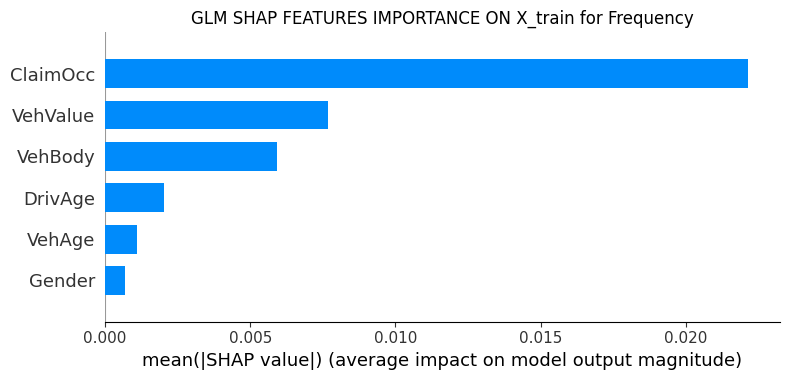

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_freq = TweedieRegressor(power=1,link='log').fit(X_train_freq_, y_train_nb/exposure_tr_freq, sample_weight=exposure_tr_freq)
masker = shap.maskers.Independent(X_train_freq_)
GLM_explainer = shap.LinearExplainer(GLM_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_freq_, feature_names=X_test_freq_.columns,plot_type='bar',max_display=10)

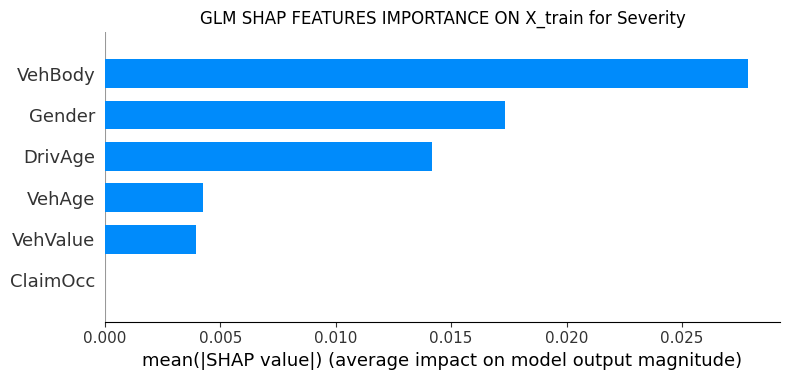

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_cost = TweedieRegressor(power=2,link='log').fit(X_train_cost_, y_train_cl, sample_weight=claim_tr)
masker = shap.maskers.Independent(X_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON X_train for Severity")
shap.summary_plot(GLM_shap_values, features=X_test_cost_, feature_names=X_test_cost_.columns,plot_type='bar',max_display=10)

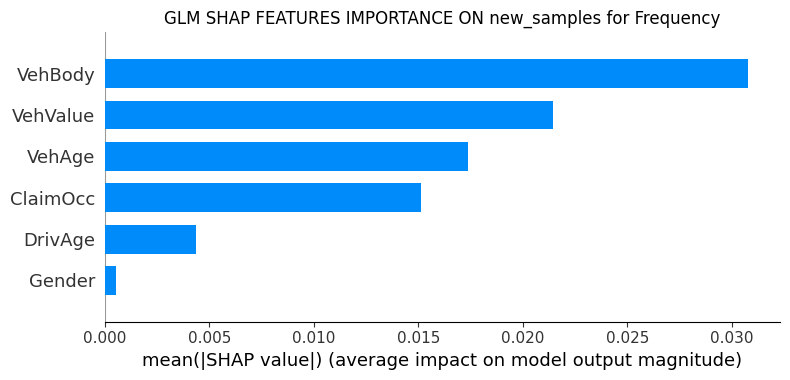

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_freq = TweedieRegressor(power=1,link='log').fit(X_train_sample_freq_, y_train_sample_nb/exposure_sample_tr_freq, sample_weight=exposure_sample_tr_freq)
masker = shap.maskers.Independent(X_train_sample_freq_)
GLM_explainer = shap.LinearExplainer(GLM_sample_freq, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_test_sample_freq_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Frequency")
shap.summary_plot(GLM_shap_values, features=X_test_sample_freq_, feature_names=X_test_sample_freq_.columns,plot_type='bar',max_display=10)

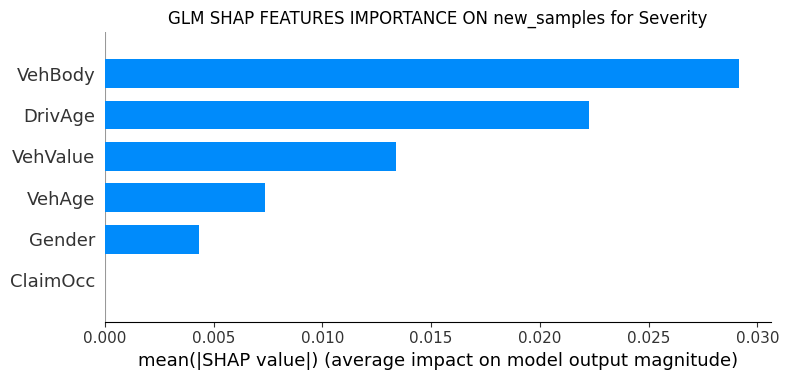

In [ ]:
# Global SHAP on GLM
np.random.seed(0)
GLM_sample_cost = TweedieRegressor(power=2,link='log').fit(X_sample_train_cost_, y_sample_train_cl, sample_weight=claim_sample_tr)
masker = shap.maskers.Independent(X_sample_train_cost_)
GLM_explainer = shap.LinearExplainer(GLM_sample_cost, masker=masker)
GLM_shap_values = GLM_explainer.shap_values(X_sample_test_cost_)
plt.rcParams['figure.figsize'] = (5,5)
plt.title("GLM SHAP FEATURES IMPORTANCE ON new_samples for Severity")
shap.summary_plot(GLM_shap_values, features=X_sample_test_cost_, feature_names=X_sample_test_cost_.columns,plot_type='bar',max_display=10)